In [1]:
import pandas as pd
import numpy as np

import chess
from stockfish import Stockfish

from collections import defaultdict

In [2]:
# CHANGE THIS CELL TO POINT TO THE STOCKFISH APP INSTALLED ON YOUR MACHINE
stockfish_path = '/opt/homebrew/bin/stockfish'

# Read in the games

## Read in the CSVs without the Stockfish evaluations

In [3]:
train_1st = pd.read_csv('../data/processed/train/train_1st.csv', index_col='name_of_pl_playing_1st_game')
test_1st = pd.read_csv('../data/processed/test/test_1st.csv', index_col='name_of_pl_playing_1st_game')
val_1st = pd.read_csv('../data/processed/val/val_1st.csv', index_col='name_of_pl_playing_1st_game')

In [4]:
#Dictionary of dataframes without Stockfish evaluations
dfs_dict = {
   'train':train_1st,
    'test':test_1st,
     'val':val_1st
}

#Dictionary of paths to text files with stockfish evaluations
stockfish_paths_dict = {
   'train':'../data/sf_evals/train',
    'test':'../data/sf_evals/test',
     'val':'../data/sf_evals/val'
}

## Read a single game's Stockfish evaluations from a text file

In [5]:
#Read a single game's Stockfish evaluations as a dictionary
example_game_number = 1234
example_kind = 'train'
example_game = eval(open(f"{stockfish_paths_dict[example_kind]}/game{example_game_number}.txt").read())

In [6]:
#Look at the first move
example_game[0]

{'eval': {'type': 'cp', 'value': 64},
 'fen': 'rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1'}

In [7]:
#Look at the second move
example_game[1]

{'eval': {'type': 'cp', 'value': 45},
 'fen': 'rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq - 0 1',
 'top_10': [{'Move': 'c7c5', 'Centipawn': 40, 'Mate': None},
  {'Move': 'e7e5', 'Centipawn': 56, 'Mate': None},
  {'Move': 'e7e6', 'Centipawn': 59, 'Mate': None},
  {'Move': 'b8c6', 'Centipawn': 70, 'Mate': None},
  {'Move': 'd7d6', 'Centipawn': 83, 'Mate': None},
  {'Move': 'd7d5', 'Centipawn': 85, 'Mate': None},
  {'Move': 'c7c6', 'Centipawn': 89, 'Mate': None},
  {'Move': 'h7h6', 'Centipawn': 91, 'Mate': None},
  {'Move': 'a7a6', 'Centipawn': 94, 'Mate': None},
  {'Move': 'h7h5', 'Centipawn': 132, 'Mate': None}]}

As we can see, this example game is one where the new player is playing Black: our script only recorded the "top 10 moves" for each of the *new player's* turns.  Let's verify that this is correct, though:

### Match the Stockfish evaluations to the new player whose game they came from

In [8]:
#Find the row whose number is the same as the number in the imported text file's name
dfs_dict[example_kind].iloc[[example_game_number]]

,opponent,new_pl_color,new_pl_won,new_pl_elo,opp_elo,new_pl_rating_diff,opp_rating_diff,game_length,time_limit,time_gain_per_move,event,termination,conceded,datetime,timestamp,moves,both_players_1st_game
name_of_pl_playing_1st_game,,,,,,,,,,,,,,,,,
boedoet10,Nanas,Black,0.0,1500.0,1908.0,-48.0,4.0,105,300.0,0.0,Blitz,Time forfeit,1,2016-07-16 05:32:47,1.468647e+09,e4 e5 Bc4 c6 Qe2 d5 exd5 cxd5 Qxe5+ Be6 Bb5+ N...,0


As we can see, this new player was indeed playing Black.  Furthermore, let's verify that all the moves made in this game result in the same positions as recorded in the imported dictionary (in the form of FEN strings):

In [9]:
def check_same_moves(game_number, kind):
    '''
    Input:
    -game_number: The number of a text file containing a dictionary of Stockfish evaluations
    for a single game
    -kind: A string 'train', 'test' or 'val'
    
    Checks if this text file does indeed correspond to the game in row game_number of the
    dataframe of the specified kind.
    The check is made by going through all the moves and checking that the resulting
    positions' FEN strings are the same as those in the dictionary.
    Returns True if everything matches up; returns False otherwise.
    '''
    #Read in the text file as a dictionary
    game = eval(open(f"{stockfish_paths_dict[kind]}/game{game_number}.txt").read())
    
    #Select the correct dataframe
    df = dfs_dict[kind]
    
    #Make a list of the moves in the game
    moves = df.iloc[game_number]['moves'].split(' ')
    
    #Initialize a chess Board
    board = chess.Board()
    
    #Check if the initial board position is the same as the one recorded in the dictionary
    same = (board.fen() == game[0]['fen'])
    
    for i, move in enumerate(moves):
        #If you've just encountered a position that is not the same as the one
        #recorded in the dictionary, then stop checking
        if not same:
            break
        
        #Otherwise, make the next move...
        board.push_san(move)
        position = board.fen()
        #... and check if the position matches the one in the dictionary after this move
        same = (position == game[i+1]['fen'])
    
    #This should be True if all positions achieved in the game are the same as those
    #that appear in the dictionary
    return same

In [10]:
#Check that our example game matches the corresponding row of our train_1st dataframe
check_same_moves(game_number = example_game_number, kind = example_kind)

True

# Check that all games' text files match the rows of our dataframe

In [11]:
def all_games_match(kind):
    '''
    Input: A string 'train', 'test' or 'val'
    
    Checks if all positions match up between the text files of Stockfish evaluations
    and the corresponding dataframe.
    '''
    
    #Get the correct dataframe
    df = dfs_dict[kind]
    
    #Loop over the games in the dataframe and check that they match the text files
    for i in range(len(df)):
        is_same = check_same_moves(game_number = i, kind = kind)
        
        #If you ever encounter a non-matching game, break out of the loop
        if not is_same:
            break
    
    #Return the result
    return is_same
    

In [12]:
matches = []
for kind in ['train', 'test', 'val']:
    matches.append(all_games_match(kind))

In [13]:
#Did all the train, test, and val games match?
matches

[True, True, True]

Since all three are `True`, we know that all of the rows of our dataframes properly correspond to the text files we have.

# Average Stockfish evaluations for identical board positions

When Stockfish is asked to evaluate a board position, it doesn't always come to the exact same numerical evaluation.  This is because it uses semi-randomized search and aggresively prunes the trees over which it will search.

Thus, if a board position appears *multiple times* across the many games in our training data set, it is likely that not all of them will have the same evaluation score or "top 10 moves" scores.  For example, let's look at the starting board position in two example games where the new player was playing White (and hence we asked Stockfish to get the top 10 moves for the initial board position):

In [74]:
game_number = 0
kind = 'train'
game0 = eval(open(f"{stockfish_paths_dict[kind]}/game{game_number}.txt").read())

#Look at the Stockfish information for the opening board position
game0[0]

{'eval': {'type': 'cp', 'value': 64},
 'top_10': [{'Move': 'e2e4', 'Centipawn': 70, 'Mate': None},
  {'Move': 'g1f3', 'Centipawn': 39, 'Mate': None},
  {'Move': 'd2d4', 'Centipawn': 30, 'Mate': None},
  {'Move': 'c2c4', 'Centipawn': 29, 'Mate': None},
  {'Move': 'e2e3', 'Centipawn': 28, 'Mate': None},
  {'Move': 'b1c3', 'Centipawn': 18, 'Mate': None},
  {'Move': 'c2c3', 'Centipawn': -9, 'Mate': None},
  {'Move': 'a2a3', 'Centipawn': -9, 'Mate': None},
  {'Move': 'h2h3', 'Centipawn': -31, 'Mate': None},
  {'Move': 'd2d3', 'Centipawn': -31, 'Mate': None}],
 'fen': 'rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1'}

In [84]:
game_number = 1
kind = 'train'
game1 = eval(open(f"{stockfish_paths_dict[kind]}/game{game_number}.txt").read())

#Look at the Stockfish information for the opening board position
game1[0]

{'eval': {'type': 'cp', 'value': 64},
 'top_10': [{'Move': 'e2e4', 'Centipawn': 70, 'Mate': None},
  {'Move': 'g1f3', 'Centipawn': 39, 'Mate': None},
  {'Move': 'd2d4', 'Centipawn': 30, 'Mate': None},
  {'Move': 'c2c4', 'Centipawn': 29, 'Mate': None},
  {'Move': 'e2e3', 'Centipawn': 28, 'Mate': None},
  {'Move': 'b1c3', 'Centipawn': 18, 'Mate': None},
  {'Move': 'c2c3', 'Centipawn': -9, 'Mate': None},
  {'Move': 'a2a3', 'Centipawn': -9, 'Mate': None},
  {'Move': 'h2h3', 'Centipawn': -31, 'Mate': None},
  {'Move': 'd2d3', 'Centipawn': -31, 'Mate': None}],
 'fen': 'rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1'}

## Blah

In [15]:
dd = defaultdict(lambda : [])

In [16]:
dd[5].append(1)

In [18]:
dd.items()

dict_items([(5, [1])])

In [19]:
dd[5]

[1]

In [26]:
dd = defaultdict(lambda : [])

fen = 'rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1'
score1 = 64
score2 = 62

dd[fen].append(score1)
dd[fen].append(score2)

In [27]:
dd[fen]

[64, 62]

In [303]:
len(bad_inds)

923

In [124]:
def add_fen_strings(game_number, df):
    '''
    Input:
    -game_number: The number of a text file containing a dictionary of Stockfish evaluations
    for a single game
    -df: A dataframe, such as "train_1st" or "test_1st" or "val_1st"
    '''
    #Read in the text file as a dictionary
    game = eval(open(f"{stockfish_train_path}/game{game_number}.txt").read())
    
    #Make a list of the moves in the game
    moves = df.iloc[game_number]['moves'].split(' ')
    
    #Initialize a chess Board
    board = chess.Board()
    
    #Add the initial FEN string
    game[0]['fen'] = board.fen()
    
    for i, move in enumerate(moves):
        #If this is the last move of the game, then there won't be a "next board position"
        if i == len(moves)-1:
            continue
        
        #Otherwise, make the next move...
        board.push_san(move)
        position = board.fen()
        #... and add its position to the dictionary
        game[i+1]['fen'] = position
    
    #Return the dictionary, now with the FEN strings added
    return game

In [306]:
bad_inds[-40]

933

In [258]:
len(bad_inds)

923

In [270]:
good_inds = [i for i in range(len(train_1st)) if i not in bad_inds]

In [271]:
len(good_inds)

19497

In [293]:
game_number = 1234
example_game = eval(open(f"{stockfish_train_path}/game{game_number}.txt").read())

moves = train_1st.iloc[game_number]['moves'].split(' ')

In [294]:
#Initialize Stockfish
#Use the same paramters we used in our evaluations of the whole games
sf = Stockfish(stockfish_path, depth=15)
sf.update_engine_parameters({
    'Threads':1,
    "Hash":1024
})

In [295]:
board = chess.Board(example_game[len(example_game)-1]['fen'])
board.push_san(moves[len(moves)-1])
final_fen = board.fen()

sf.set_fen_position(final_fen)
sf.get_evaluation()

{'type': 'cp', 'value': 2060}

In [279]:
good_checkmate_inds = []

for i in range(len(good_inds)):
    game = eval(open(f"{stockfish_train_path}/game{good_inds[i]}.txt").read())
    fen = game[len(game)-1]['fen']
    board = chess.Board(fen)
    if board.is_checkmate():
        good_checkmate_inds.append(i)

In [280]:
len(good_checkmate_inds)

0

In [276]:
bad_checkmate_inds = []

for i in range(len(bad_inds)):
    added = add_fen_strings(bad_inds[i], train_1st)
    fen = added[len(added)-1]['fen']
    board = chess.Board(fen)
    if board.is_checkmate():
        bad_checkmate_inds.append(i)

KeyboardInterrupt: 

In [ ]:
len(checkmate_inds)

In [249]:
board=chess.Board(fen)

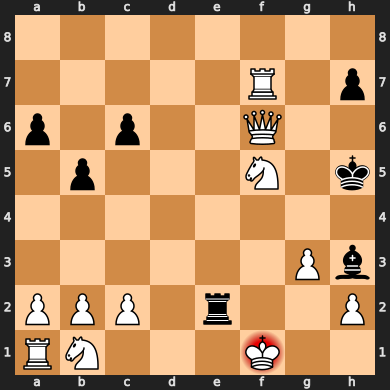

In [250]:
board

In [251]:
bad_inds[103]

103

In [253]:
train_1st.iloc[[103]]

,opponent,new_pl_color,new_pl_won,new_pl_elo,opp_elo,new_pl_rating_diff,opp_rating_diff,game_length,time_limit,time_gain_per_move,event,termination,conceded,datetime,timestamp,moves,both_players_1st_game
name_of_pl_playing_1st_game,,,,,,,,,,,,,,,,,
nasenhaare2,ecso,White,1.0,1500.0,1240.0,81.0,-4.0,59,300.0,0.0,Blitz,Normal,1,2016-07-14 11:21:15,1.468495e+09,d4 e6 Bf4 d6 Nf3 g5 Bxg5 f6 Bh4 Qe7 e4 c6 Bc4 ...,0


In [308]:
def check_same_moves_simon(game_number, df):
    '''
    Input:
    -game_number: The number of a text file containing a dictionary of Stockfish evaluations
    for a single game
    -df: A dataframe, such as "train_1st" or "test_1st" or "val_1st"
    
    Checks if this text file does indeed correspond to the game in row game_number of the
    dataframe df.
    That dataframe must contain a column called "moves" that is a space-separated string
    of the moves made in that game.  The check is made by going through all the moves and
    checking that the resulting positions' FEN strings are the same as those in the
    dictionary.
    Returns True if everything matches up; returns False otherwise.
    '''
    #Read in the text file as a dictionary
    game = eval(open(f"../data/stockfish_evals/simon_trial/game{game_number}.txt").read())
    
    #Make a list of the moves in the game
    moves = df.iloc[game_number]['moves'].split(' ')
    
    #Initialize a chess Board
    board = chess.Board()
    
    #Check if the initial board position is the same as the one recorded in the dictionary
    same = (board.fen() == game[0]['fen'])
    
    for i, move in enumerate(moves):
        #If you've just encountered a position that is not the same as the one
        #recorded in the dictionary, then stop checking
        if not same:
            break
            
        #If this is the last move of the game, then there won't be a "next board position"
        #to evaluate.  Skip it.
        if i == len(moves)-1:
            continue
        
        #Otherwise, make the next move...
        board.push_san(move)
        position = board.fen()
        #... and check if the position matches the one in the dictionary after this move
        same = (position == game[i+1]['fen'])
    
    #This should be True if all positions achieved in the game are the same as those
    #that appear in the dictionary
    return same

In [310]:
for i in bad_inds:
    if not check_same_moves_simon(i, train_1st):
        print(f"Bad game: {i}")

In [ ]:
for i in bad_inds

In [313]:
len(os.listdir('../data/stockfish_evals/train'))

20420